# STA 863 Final Project - FHMM
*Factorial Hidden Markov Models* - Gharamani and Jordan


In [137]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.stats import multivariate_normal
import seaborn as sns
np.random.seed(17)

## 1. Generate Toy Data and Parameters

$$P({S_t, Y_t}) = P(S_1)P(Y_1 | S_1)\prod_{t=2}^T P(S_t | S_{t-1})P(Y_t | S_t)$$

- Assume three different chains, each with 5 hidden states each
- M = 3, K = (5, 5, 5)
- n = 10 observations, D = 3 (dimension of Gaussian)
- Normal Model

In [731]:
M = 3 ## Number of independent hidden state chains
K = np.array([5, 5, 5]) ## number of hidden states for each chain
D = 3 ## Dimension of Gaussian
n = 10 ## number of observations


## Generate distribtions
pi = [] ## initial distribution
Tmat = []  ## transition distribution
W = [] ## contribution to means matrices D x K
for i in range(0, M):
    vals = np.random.rand(K[i])
    pi.append(vals/np.sum(vals))
    vals1 = np.random.rand(K[i], K[i])
    Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
    W.append(10*np.random.rand(D, K[i]))
    
## Generate state variables
S = []
for i in range(0, M):
    zstates = np.arange(0, K[i], dtype = int)
    z = np.zeros(n, dtype = int)
    zmat = np.zeros((K[i], n), dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
    zmat[z[0], 0] = 1
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        zmat[z[j], j] = 1
    S.append(zmat)
#x = np.random.normal(size=D)
#y = np.random.normal(size=D)
#z = np.vstack((x, y))
#C = np.cov(z.T) ## covariance matrix
C = np.identity(D)
mu = np.zeros((D, n))
Y = np.zeros((D, n))
for t in range(0, n):
    for i in range(0, M):
        mu[:, t] += np.dot(W[i], S[i][:, t])
    Y[:, t] = np.random.multivariate_normal(mu[:, t], C, 1)


In [783]:
print("Pi")
print(np.round(pi, 3))
print("Tmat")
print(np.round(Tmat, 3))
print("W")
print(np.round(W, 3))
print("C")
print(np.round(C, 3))
print("Z states")
print([np.where(S[0][:, t] == 1)[0][0] for t in range(n)])
print([np.where(S[1][:, t] == 1)[0][0] for t in range(n)])
print([np.where(S[2][:, t] == 1)[0][0] for t in range(n)])
print('Log-Likelihood')
zstore = [[np.where(S[0][:, t] == 1)[0][0] for t in range(n)], [np.where(S[1][:, t] == 1)[0][0] for t in range(n)],
         [np.where(S[2][:, t] == 1)[0][0] for t in range(n)]]
log_like(n, pi, Tmat, mu, C, Y, zstore)

Pi
[[ 0.396  0.239  0.024  0.224  0.117]
 [ 0.001  0.217  0.196  0.026  0.561]
 [ 0.227  0.275  0.257  0.23   0.011]]
Tmat
[[[ 0.18   0.111  0.197  0.113  0.399]
  [ 0.053  0.364  0.171  0.258  0.154]
  [ 0.239  0.215  0.215  0.252  0.079]
  [ 0.218  0.408  0.151  0.138  0.086]
  [ 0.082  0.275  0.254  0.222  0.166]]

 [[ 0.248  0.374  0.22   0.042  0.117]
  [ 0.075  0.022  0.182  0.382  0.339]
  [ 0.003  0.591  0.171  0.21   0.025]
  [ 0.158  0.053  0.277  0.213  0.299]
  [ 0.275  0.143  0.311  0.172  0.098]]

 [[ 0.155  0.264  0.304  0.161  0.115]
  [ 0.077  0.13   0.214  0.192  0.387]
  [ 0.241  0.345  0.015  0.333  0.066]
  [ 0.084  0.291  0.059  0.329  0.238]
  [ 0.212  0.157  0.272  0.16   0.198]]]
W
[[[ 5.874  5.457  6.191  3.636  6.132]
  [ 7.786  5.427  9.283  8.23   7.883]
  [ 1.339  9.995  8.773  0.027  1.864]]

 [[ 8.671  4.592  6.147  6.955  5.705]
  [ 3.524  9.588  7.13   2.581  5.816]
  [ 6.532  5.512  8.785  5.741  1.108]]

 [[ 7.033  1.796  6.158  2.1    2.387]
  [ 6.1

-38.489202813540778

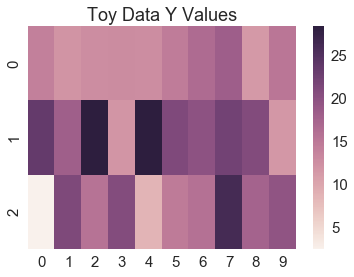

In [741]:
sns.heatmap(Y)
plt.title("Toy Data Y Values")
pass

# E - Step

## 2. Gibbs Sampling 

$$S_t^{(m)} \propto P(S_t^{(m)} | S_{t-1}^{(m)})P(S_{t+1}|S_t^{(m)})P(Y_t | S_t^{(1)}, \ldots, S_t^{(M)})$$

In [816]:
# Calculate transition matrix from a vector
# q is a vector from 0 to m different states
# return m x m transition matrix b
from collections import Counter
def trans_mat(q, m):
    b = np.zeros((m,m))
    for (x,y), c in Counter(zip(q, q[1:])).items():
        b[x, y] = c
    return(b)


# t is the time step to be updated
# y is the observed value at that time step
# M is the number of hidden Markov chains
# K is a vector of number of hidden states for each chain
# C is covariance matrix for emission distribution
# W is a list of M D x K matrix, columns contribution to mean of each state variable 
# S is a M long list of current states, each element of list is K[i] x n long (n number of observations)
# update is which of M chains to calculate emission probabilities for, for every K[i] possible values
# output is a K[update] vector of density of y for each possible value of S[update]
def y_density(t, y, M, K, S, C, W, update):
    ydense = np.zeros(K[update]) ## output density for each possible value of S[update]
    Stemp = S
    for i in range(0, K[update]):
        mu = 0
        Stemp[update][:, t] = 0
        Stemp[update][i, t] = 1 # state variable value to calculate probability for
        for j in range(0, M):
            mu += np.dot(W[j], Stemp[j][:, t])
        ydense[i] = multivariate_normal.pdf(y, mean = mu, cov = C)
    return(ydense)



# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# it is the number of iterations to run for the Gibbs Sampler
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10):
    # Randomly initialize state vectors
    S = []
    zstates = []
    for i in range(0, M):
        s = np.zeros((K[i], n), dtype = int)
        ind = np.random.choice(range(0, K[i]), n)
        s[ind, range(0, n)] = 1
        zz = np.zeros((it, n), dtype = int)
        zz[0, :] = ind
        zstates.append(zz)
        S.append(s)
        
    for l in range(1, it):
        ## update one  chain at a time
        for i in range(0, M):
            ## step through each time point
            for t in range(0, n):
                ## select P(S_t | S_t-1)
                if t == 0:
                    tback = np.ones(K[i])
                else:
                    prev = zstates[i][l-1, t-1]
                    tback = Tmat[i][prev, :]
                ## select P(S_t+1 | S_t)
                if t == (n-1):
                    tfore = np.ones(K[i])
                else:
                    fore = zstates[i][l-1, t]
                    tfore = Tmat[i][fore, :]
                ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
                ydense = y_density(t, Y[:, t], M, K, S, C, W, i)
                
                ## Calculate probability for each state for S_t^i
                probvec = np.multiply(np.multiply(tback, tfore) , ydense)
                print(probvec)
                if np.sum(probvec) == 0: # check if all states have 0 probability
                    probvec = np.ones(len(probvec)) # reset to equal probs if so
                probvec = probvec/sum(probvec)
                ## sample state and update vector
                zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
                S[i][zstates[i][l, t], t] = 1
    
    ## Calculate expectations
    # <S_t^(m)>
    St = []
    Smm = []
    for i in range(0, M):
        uprobs = [np.unique(zstates[i][:, t], return_counts = True)[1]/it for t in range(0,n)] # calculate probs
        zmat = np.zeros((n, K[i]))
        inds = [np.unique(zstates[i][:, t], return_counts = True)[0] for t in range(0,n)]
        for t in range(n):
            zmat[t, inds[t]] = uprobs[t]
        St.append(zmat)
        # calculate trans mat
        Smm.append(np.stack([trans_mat(zstates[i][:, t], K[i])/(it-1) for t in range(0, n)], axis = 2))  
    
    # <S_t^(m)S_t^(n)>
    Snm = np.zeros((sum(K), sum(K), n))
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    s1 = np.zeros((K[i], K[i]))
                    mm = np.unique(zstates[i][:, t], return_counts = True)
                    s1[mm[0], mm[0]] = mm[1]/it
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = s1
                s2 = np.zeros((K[i], K[j]))
                for l in range(0, it):
                    s2[zstates[i][l, t], zstates[j][l, t]] += 1
                Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = s2/it
    
    return(St, Smm, Snm)

## 3. Completely Factorized VI

In [836]:
# Softmax operator on input vector x
def softmax(x):
    return(exp(x)/sum(exp(x)))


# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# tol is the tolerance for convergence of the KL divergence to stop the iterations
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def factorized_VI(n, M, K, Y, pi, Tmat, W, C, tol):
    D = Y.shape[0]
    thetaOld = []
    thetaNew = []
    for i in range(M):
        vals1 = np.random.rand(K[i], n)
        thetaOld.append(vals1/np.sum(vals1, axis=0)[None, :])
        thetaNew.append(np.zeros((K[i], n)))
        
    KLOld = 10E10
    convergence = 0
    iterations = 0
    while(convergence == 0):
        for i in range(M):
            for t in range(n):
                ## Calculate Y tilde
                s1 = np.zeros((D, K[i]))
                for j in np.delete(np.arange(M), i):
                    s1 += np.dot(W[j], theta[j][:, t])
                Ytilde = Y[:, t] - s1
                ## Calculate delta term
                delta = np.dot(W[i].transpose(), np.dot(np.linalg.inv(C), W[i])).diagonal()
                ## Calculate first term
                term1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), Ytilde)
                term2 = delta/2
                if t > 0:
                    term3 = np.dot(np.log(Tmat[i]), thetaOld[i][:, t-1])
                else:
                    term3 = np.log(pi[i])
                if t < n-1:
                    term4 = np.dot(np.log(Tmat[i]).transpose(), thetaOld[i][:, t+1])
                else:
                    term4 = np.zeros(K[i])
                ## Find sum
                sumterm = term1 - term2 + term3 + term4
                thetaNew[i][:, t] = softmax(sumterm)
        
                
        
        
        
        ## Check KL divergence
        
        
        
        KLNew = log_like(n, pi, Tmat, mu, C, Y, zstore)  
        criteria = abs(KLOld - KLNew)
        if criteria < tol:
            convergence = 1
        else:
            convergence = 0
            KLOld = KLNew
            thetaOld = thetaNew
    
        iterations += 1
    
    ## Find expectations
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    # Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
    # Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
    St = [np.zeros((K[i], n)) for i in range(M)]
    Smm = [np.zeros((K[i], K[i], n)) for i in range(M)]
    Snm = np.zeros((np.sum(K), np.sum(K), n))
    for i in range(M):
        for t in range(n):
            St[i][:, t] = thetaNew[i][:, t]
            if t == 0:
                Smm[i][:, :, t] = np.outer(pi[i], thetaNew[i][:, t])
            else:
                Smm[i][:, :, t] = np.outer(thetaNew[i][:, t-1], thetaNew[i][:, t])
    
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = np.diag(thetaNew[i][:, t])
                else:
                    Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = np.dot(thetaNew[i][:, t], 
                                                                      thetaNew[j][:, t].transpose())
                
    
            
    
            
    
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-836-73d0388548d0>, line 91)

In [838]:
np.diag([5, 5])

array([[5, 0],
       [0, 5]])

In [827]:
vals1 = np.random.rand(n, 5)
np.round(vals1/np.sum(vals1, axis=1)[:,None], 2)

array([[ 0.19,  0.53,  0.01,  0.21,  0.06],
       [ 0.11,  0.22,  0.15,  0.22,  0.3 ],
       [ 0.23,  0.17,  0.32,  0.22,  0.06],
       [ 0.12,  0.43,  0.12,  0.32,  0.01],
       [ 0.13,  0.25,  0.12,  0.23,  0.28],
       [ 0.28,  0.21,  0.25,  0.05,  0.2 ],
       [ 0.1 ,  0.16,  0.18,  0.27,  0.29],
       [ 0.05,  0.33,  0.25,  0.23,  0.14],
       [ 0.28,  0.14,  0.11,  0.18,  0.29],
       [ 0.26,  0.05,  0.24,  0.32,  0.13]])

In [822]:
np.sum(vals1/np.sum(vals1, axis=1)[:,None], axis = 0)

array([ 0.36317085,  0.61709765,  0.47121337,  0.50680089,  0.32600906,
        0.56049388,  0.56778762,  0.48859952,  0.65815573,  0.44067144])

In [829]:
np.sum((vals1/np.sum(vals1, axis=1)[:,None])[0, :])

0.99999999999999989

# M-Step

## 5. M-Step

$$ n = T$$
$$W^{new} = \left(\sum_{t=1}^T Y_t<S_t'>\right)\left(\sum_{t=1}^T<S_tS_t'>\right)^{\dagger}$$

** Add other update equations **

In [743]:
# M is number of hidden state Markov chains
# K is vector of number of hidden states for each Markov chain
# Y is the D x n matrix of observations
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
# output is a tuple of updated values from the M step
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations

def Mstep(M, K,  Y, St, Smm, Snm):
    ### Update W ###
    # Concatenate St to be sum(K) x 1 x t
    cSt = np.vstack([np.vstack(St[i]).transpose() for i in range(0, len(St))])
    s1 = np.dot(Y, cSt.transpose()) # first sum for Wnew
    s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
    Wnew = np.dot(s1, s2)
    # make Wnew back into list of matrices
    W = []
    pi = []
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0)
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for i in range(0, M):
        W.append(Wnew[:, ind1[i]:ind2[i]])
        ### Update pi ###
        pi.append(cSt[ind1[i]:ind2[i], 0])

    ### Update Transition matrices ###
    Tmat = []
    St = [np.vstack(St[i]) for i in range(0, M)] ## stack St matrices for easier indexing
    for i in range(0, M):
        Tnew = np.zeros((K[i], K[i]))
        for j in range(0, K[i]):
            for l in range(0, K[i]):
                Tnew[j,l] =  np.sum(Smm[i][j, l, :])/sum(St[i][l, 0:(n-1)])
        Tnew = Tnew/np.sum(Tnew, axis=1)[:,None]
        Tmat.append(Tnew)

    ### Update C covariance ###
    #s1 = np.dot(Y, Y.transpose())/n
    #s2 = np.zeros((D, D))
    #for t in range(0, n):
    #    for i in range(0, M):
    #        mult1 = np.dot(W[i], St[i][t, :])
    #        s2 += np.outer(mult1, Y[:, t].transpose())
    #C = s1 - s2/n
    mutemp = np.zeros((D, n))
    for i in range(0, M):
        mutemp += np.dot(W[i], np.vstack(St[i]).transpose())
    C = np.dot(Y - mutemp, (Y - mutemp).transpose())/n
    
    return(W, pi, Tmat, C)

In [550]:
test = np.dot(Y, Y.transpose())/n - 100*np.identity(3)/n
np.all(np.linalg.eigvals(test) > 0)

False

In [584]:
Smm[0][:, :, 0]/np.sum(Smm[0][:, :, 0])

1.0

In [586]:
Smm[0][:, :, 0]

array([[ 0. ,  0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0.1,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0.1,  0.2],
       [ 0. ,  0.1,  0.1,  0. ,  0. ]])

In [180]:
test = np.random.rand(3, 5)
tt = [2,3]
test

array([[ 0.32630789,  0.21268374,  0.44099242,  0.02005337,  0.80203217],
       [ 0.09690038,  0.24040777,  0.8267097 ,  0.46484536,  0.0639569 ],
       [ 0.05535868,  0.36112397,  0.18277368,  0.62832175,  0.69406504]])

In [196]:
#K + 
np.insert(np.cumsum(K[1:]), 0, 0)

array([ 0,  5, 10])

In [197]:
K + np.insert(np.cumsum(K[1:]), 0, 0)

array([ 5, 10, 15])

In [172]:
i = np.array([3, 3, 2])
0 + i[1:]

array([3, 2])

In [193]:
np.cumsum(K[1:])

array([ 5, 10])

# 6. Inference: Run E-M Steps

In [744]:
# Calculate log likelihood
# n is number of observations
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations 
# mu is a D x n mean matrix
def log_like(n, pi, Tmat, mu, C, Y, zstates):
    y_prob = np.zeros(n) # emission probabilities
    t_prob = 0 # transition matrix probabilities
    pi_prob = 0 # initial probability
    for i in range(0, M):
            pi_prob += np.log(pi[i][zstates[i][0]])
    
    for t in range(0, n):
        y_prob[t] = np.log(multivariate_normal.pdf(Y[:, t], mean = mu[:, t], cov = C))  
        
        for i in range(0, M):
            t_prob += Tmat[i][zstates[i][t-1], zstates[i][t]]
    ll = pi_prob + t_prob + np.sum(y_prob)        
    return(ll)

In [787]:
# Y is D x n observation matrix
# M is number of hidden markov chains
# K is an 1 x M vector of the number of hidden states for each chain
# tol = tolerance for convergence
# inference is inference method to use, choices = Gibbs, 
def FHMM(Y, M, K, tol, inference):
    D, n = Y.shape
    ## Initialize params
    pi = [] ## initial distribution
    Tmat = []  ## transition distribution
    W = [] ## contribution to means matrices D x K
    for i in range(0, M):
        vals = np.random.rand(K[i])
        pi.append(vals/np.sum(vals))
        vals1 = np.random.rand(K[i], K[i])
        Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
        W.append(10*np.random.rand(D, K[i]))
    C = np.identity(D)
    
    convergence = 0
    pOld = 10E10
    iterations = 0
    while(convergence == 0):
        
        ## E - Step
        if inference == "Gibbs":
            St, Smm, Snm = gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10)
            
        ## M - Step
        W, pi, Tmat, C = Mstep(M, K,  Y, St, Smm, Snm)
        
        ## Check tolerance
        # sample S with new params
        ## Generate state variables
        S = []
        mu = np.zeros((D, n))
        zstore = []
        for i in range(0, M):
            zstates = np.arange(0, K[i], dtype = int)
            z = np.zeros(n, dtype = int)
            zmat = np.zeros((K[i], n), dtype = int)
            z[0] = np.random.choice(zstates, size = 1, p = pi[i])
            zmat[z[0], 0] = 1
            for j in range(1, n):
                z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
                zmat[z[j], j] = 1
            S.append(zmat)
            zstore.append(z)
        for i in range(0, M):
            for j in range(1, n):
                mu[:, j] += np.dot(W[i], S[i][:, j])
        
        pNew = log_like(n, pi, Tmat, mu, C, Y, zstore)  
        criteria = abs(pOld - pNew)
        if criteria < tol:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
    
        iterations += 1
        print(iterations)
        print(pNew)
    return(pi, Tmat, mu, C, W, zstore)
                    

In [817]:
pi_new, Tmat_new, mu_new, C_new, W_new, zstore = FHMM(Y, M, K, 1, "Gibbs")

[  1.47880854e-48   4.77586991e-81   3.77883951e-44   2.95109059e-50
   1.11615702e-50]
[  9.99220387e-39   4.61606395e-24   8.48319733e-25   1.38320436e-20
   1.35993403e-21]
[  2.08705173e-115   3.45557393e-109   8.69736400e-103   1.44852602e-109
   9.10883640e-074]
[  4.96311665e-16   1.17415965e-16   5.50974188e-12   6.29187119e-09
   5.96036283e-22]
[  3.96107609e-76   1.02626908e-74   5.94404502e-62   1.30906175e-65
   7.62385747e-45]
[  4.54590360e-55   5.15660780e-60   2.51549225e-50   3.65969994e-56
   6.26662905e-35]
[  3.84530318e-19   1.23474016e-09   1.06270371e-13   1.25195218e-13
   2.07583628e-04]
[  1.18209825e-90   4.72437818e-35   6.36504624e-73   5.25144701e-66
   6.29627429e-42]
[  1.63287056e-58   5.41185575e-43   1.73472619e-43   1.14011627e-45
   2.22702231e-23]
[  6.51434942e-38   5.32557268e-18   1.11647216e-25   1.53296098e-20
   2.84964986e-26]
[  6.18043076e-101   2.58319786e-127   1.94067324e-119   2.23583659e-102
   8.94065801e-088]
[  1.56761433e-10   1.

In [781]:
C

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [782]:
C_new

array([[  3.48553287,  -0.96006789,   2.95251304],
       [ -0.96006789,  24.33658952, -13.81074082],
       [  2.95251304, -13.81074082,  33.35332242]])

In [810]:
D, n = Y.shape
M = 3
K = np.array([5,5,5])
## Initialize params
pi_new = [] ## initial distribution
Tmat_new = []  ## transition distribution
W_new = [] ## contribution to means matrices D x K
for i in range(0, M):
    vals = np.random.rand(K[i])
    pi_new.append(vals/np.sum(vals))
    vals1 = np.random.rand(K[i], K[i])
    Tmat_new.append(vals1/np.sum(vals1, axis=1)[:,None])
    W_new.append(np.random.rand(D, K[i]))
C_new = np.identity(D)

convergence = 0
pOld = 10E10
it = 15

In [811]:
pi_new

[array([ 0.36189562,  0.03598997,  0.07976232,  0.25702478,  0.26532732]),
 array([ 0.36466991,  0.2556416 ,  0.11010354,  0.1697221 ,  0.09986286]),
 array([ 0.17888365,  0.21987834,  0.29687933,  0.0976606 ,  0.20669808])]

In [812]:
St, Smm, Snm = gibbs_sampler(n, M, K, Y, Tmat_new, W_new, C_new, it = 10)

In [813]:
W_new, pi_new, Tmat_new, C_new = Mstep(M, K,  Y, St, Smm, Snm)

In [814]:
np.all(np.linalg.eigvals(C_new) > 0)

True

In [815]:
Tmat_new

[array([[ 0.88888889,  0.        ,  0.        ,  0.        ,  0.11111111],
        [ 0.        ,  0.42857143,  0.        ,  0.        ,  0.57142857],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.25      ,  0.        ,  0.        ,  0.        ,  0.75      ],
        [ 0.        ,  0.15517241,  0.01724138,  0.        ,  0.82758621]]),
 array([[ 0.        ,  0.25      ,  0.75      ,  0.        ,  0.        ],
        [ 0.        ,  0.53333333,  0.46666667,  0.        ,  0.        ],
        [ 0.01492537,  0.07462687,  0.85074627,  0.05970149,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ]]),
 array([[ 0.76666667,  0.        ,  0.23333333,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.61538462,  0.        ,  0.38461538,  0.        ,  0.        ],
        [ 1.        ,

In [717]:
S = []
mu = np.zeros((D, n))
zstore = []
for i in range(0, M):
    zstates = np.arange(0, K[i], dtype = int)
    z = np.zeros(n, dtype = int)
    zmat = np.zeros((K[i], n), dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
    zmat[z[0], 0] = 1
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        zmat[z[j], j] = 1
    S.append(zmat)
    zstore.append(z)
for i in range(0, M):
    for j in range(1, n):
        mu[:, j] += np.dot(W[i], S[i][:, j])

pNew = log_like(n, pi, Tmat, mu, C, Y, zstore)  
criteria = abs(pOld - pNew)

IndexError: too many indices for array

In [ ]:

y_prob = np.zeros(n) # emission probabilities
t_prob = 0 # transition matrix probabilities
pi_prob = 0 # initial probability
for i in range(0, M):
        pi_prob += np.log(pi[i][zstates[i][0]])

for t in range(0, n):
    y_prob[t] = np.log(multivariate_normal.pdf(Y[:, t], mean = mu[:, t], cov = C))  

    for i in range(0, M):
        t_prob += Tmat[i][zstates[i][t-1, t]]
ll = pi_prob + t_prob + np.sum(y_prob)        


In [727]:
Tmat[0][zstore[0][3], zstore[0][4]]

0.46874999999999994

In [639]:
# Randomly initialize state vectors
S = []
zstates = []
for i in range(0, M):
    s = np.zeros((K[i], n), dtype = int)
    ind = np.random.choice(range(0, K[i]), n)
    s[ind, range(0, n)] = 1
    zz = np.zeros((it, n), dtype = int)
    zz[0, :] = ind
    zstates.append(zz)
    S.append(s)

for l in range(1, it):
    ## update one  chain at a time
    for i in range(0, M):
        ## step through each time point
        for t in range(0, n):
            ## select P(S_t | S_t-1)
            if t == 0:
                tback = np.ones(K[i])
            else:
                prev = zstates[i][l-1, t-1]
                tback = Tmat[i][prev, :]
            ## select P(S_t+1 | S_t)
            if t == (n-1):
                tfore = np.ones(K[i])
            else:
                fore = zstates[i][l-1, t]
                tfore = Tmat[i][fore, :]
            ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
            ydense = y_density(t, Y[:, t], M, K, S, C, W, i)

            ## Calculate probability for each state for S_t^i
            probvec = np.multiply(np.multiply(tback, tfore) , ydense)
            probvec = probvec/sum(probvec)
            ## sample state and update vector
            zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
            S[i][zstates[i][l, t], t] = 1



In [640]:
zstates

[array([[2, 3, 0, 2, 0, 0, 1, 2, 1, 3],
        [3, 1, 1, 2, 3, 3, 2, 3, 2, 3],
        [4, 3, 2, 3, 4, 4, 1, 4, 3, 2],
        [4, 4, 1, 2, 4, 2, 2, 0, 3, 3],
        [2, 0, 2, 3, 3, 2, 3, 2, 1, 3],
        [3, 2, 4, 3, 1, 4, 4, 4, 0, 3],
        [1, 1, 1, 4, 3, 0, 0, 2, 2, 3],
        [2, 0, 0, 2, 4, 1, 3, 3, 3, 4],
        [4, 3, 1, 1, 2, 2, 3, 1, 1, 1],
        [3, 4, 4, 3, 1, 3, 1, 1, 3, 2],
        [4, 2, 2, 2, 2, 4, 3, 2, 1, 1],
        [2, 2, 2, 3, 4, 2, 0, 1, 2, 0],
        [3, 3, 3, 3, 4, 3, 2, 3, 3, 1],
        [4, 4, 4, 4, 2, 2, 4, 4, 1, 1],
        [0, 2, 2, 0, 3, 3, 2, 2, 0, 1]]),
 array([[2, 0, 3, 3, 1, 1, 3, 0, 1, 2],
        [2, 2, 4, 3, 3, 4, 4, 4, 1, 1],
        [4, 2, 0, 1, 2, 4, 1, 4, 0, 1],
        [1, 4, 0, 2, 2, 1, 1, 2, 2, 4],
        [1, 1, 3, 0, 0, 0, 3, 0, 2, 4],
        [4, 3, 3, 4, 2, 4, 2, 4, 4, 0],
        [4, 4, 3, 4, 4, 4, 4, 4, 4, 4],
        [1, 1, 2, 1, 4, 1, 2, 4, 1, 2],
        [2, 1, 2, 2, 1, 2, 2, 4, 4, 3],
        [0, 0, 1, 2, 4, 0, 0, 2, 4, 4]

In [663]:
## Calculate expectations
# <S_t^(m)>
St = []
Smm = []
for i in range(0, M):
    uprobs = [np.unique(zstates[i][:, t], return_counts = True)[1]/it for t in range(0,n)] # calculate probs
    zmat = np.zeros((n, K[i]))
    inds = [np.unique(zstates[i][:, t], return_counts = True)[0] for t in range(0,n)]
    for t in range(n):
        zmat[t, inds[t]] = uprobs[t]
    St.append(zmat)
    # calculate trans mat
    Smm.append(np.stack([trans_mat(zstates[i][:, t], K[i])/(it-1) for t in range(0, n)], axis = 2)) 


In [662]:
np.sum(Smm[0][:, :, 0])

0.99999999999999989

In [654]:
zstates[0][:, 0]

array([2, 3, 4, 4, 2, 3, 1, 2, 4, 3, 4, 2, 3, 4, 0])

In [634]:
zmat = np.zeros((n, K[i]))
inds = [np.unique(zstates[i][:, t], return_counts = True)[0] for t in range(0,n)]
for t in range(n):
    zmat[t, inds[t]] = uprobs[t]
zmat

array([[ 0.3,  0.2,  0.1,  0.1,  0.3],
       [ 0. ,  0.2,  0. ,  0. ,  0.8],
       [ 0. ,  0. ,  0.3,  0. ,  0.7],
       [ 0. ,  0. ,  0.2,  0.1,  0.7],
       [ 0. ,  0.3,  0.1,  0. ,  0.6],
       [ 0. ,  0.1,  0.2,  0. ,  0.7],
       [ 0.1,  0.1,  0.4,  0. ,  0.4],
       [ 0.1,  0. ,  0.2,  0. ,  0.7],
       [ 0. ,  0.1,  0.1,  0.1,  0.7],
       [ 0.1,  0.1,  0.1,  0. ,  0.7]])

In [632]:
inds = [np.unique(zstates[i][:, t], return_counts = True)[0] for t in range(0,n)]
inds

[array([0, 1, 2, 3, 4]),
 array([1, 4]),
 array([2, 4]),
 array([2, 3, 4]),
 array([1, 2, 4]),
 array([1, 2, 4]),
 array([0, 1, 2, 4]),
 array([0, 2, 4]),
 array([1, 2, 3, 4]),
 array([0, 1, 2, 4])]

In [631]:
zmat = [np.zeros(K[i]) for t in range(n)]
zmat

[array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.])]

In [664]:
zstates

[array([[2, 3, 0, 2, 0, 0, 1, 2, 1, 3],
        [3, 1, 1, 2, 3, 3, 2, 3, 2, 3],
        [4, 3, 2, 3, 4, 4, 1, 4, 3, 2],
        [4, 4, 1, 2, 4, 2, 2, 0, 3, 3],
        [2, 0, 2, 3, 3, 2, 3, 2, 1, 3],
        [3, 2, 4, 3, 1, 4, 4, 4, 0, 3],
        [1, 1, 1, 4, 3, 0, 0, 2, 2, 3],
        [2, 0, 0, 2, 4, 1, 3, 3, 3, 4],
        [4, 3, 1, 1, 2, 2, 3, 1, 1, 1],
        [3, 4, 4, 3, 1, 3, 1, 1, 3, 2],
        [4, 2, 2, 2, 2, 4, 3, 2, 1, 1],
        [2, 2, 2, 3, 4, 2, 0, 1, 2, 0],
        [3, 3, 3, 3, 4, 3, 2, 3, 3, 1],
        [4, 4, 4, 4, 2, 2, 4, 4, 1, 1],
        [0, 2, 2, 0, 3, 3, 2, 2, 0, 1]]),
 array([[2, 0, 3, 3, 1, 1, 3, 0, 1, 2],
        [2, 2, 4, 3, 3, 4, 4, 4, 1, 1],
        [4, 2, 0, 1, 2, 4, 1, 4, 0, 1],
        [1, 4, 0, 2, 2, 1, 1, 2, 2, 4],
        [1, 1, 3, 0, 0, 0, 3, 0, 2, 4],
        [4, 3, 3, 4, 2, 4, 2, 4, 4, 0],
        [4, 4, 3, 4, 4, 4, 4, 4, 4, 4],
        [1, 1, 2, 1, 4, 1, 2, 4, 1, 2],
        [2, 1, 2, 2, 1, 2, 2, 4, 4, 3],
        [0, 0, 1, 2, 4, 0, 0, 2, 4, 4]

In [679]:
# <S_t^(m)S_t^(n)>
Snm = np.zeros((sum(K), sum(K), n))
ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
for t in range(0, n):
    for i in range(0, M):
        for j in range(0, M):
            if i == j:
                s1 = np.zeros((K[i], K[i]))
                mm = np.unique(zstates[i][:, t], return_counts = True)
                s1[mm[0], mm[0]] = mm[1]/it
                Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = s1
            s2 = np.zeros((K[i], K[j]))
            for l in range(0, it):
                s2[zstates[i][l, t], zstates[j][l, t]] += 1
            Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = s2/it
    

In [684]:
np.sum(Snm[:,:,0][0:5, 5:10])

1.0

In [539]:
St, Smm, Snm = gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [528]:

## E - Step

St, Smm, Snm = gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10)

## M - Step
W, pi, Tmat, C = Mstep(M, K,  Y, St, Smm, Snm)

## Check tolerance
# sample S with new params
## Generate state variables
S = []
mu = np.zeros((D, n))
zstates = []
for i in range(0, M):
    zstates = np.arange(0, K[i], dtype = int)
    z = np.zeros(n, dtype = int)
    zmat = np.zeros((K[i], n), dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
    zmat[z[0], 0] = 1
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        zmat[z[j], j] = 1
    S.append(zmat)
    zstates.apend(z)
for i in range(0, M):
    for j in range(1, n):
        mu[:, j] += np.dot(W[i], S[i][:, j])

pNew = log_like(n, pi, Tmat, mu, C, Y, zstates)  
criteria = abs(pOld - pNew)
if criteria < tol:
    convergence = 1
else:
    convergence = 0
    pOld = pNew

ValueError: the input matrix must be positive semidefinite

In [529]:
C

array([[  626.17985738,   727.85270674,   595.5486112 ],
       [ 1007.26455405,  1273.85777935,   982.22987698],
       [  654.01008759,   782.67253069,   642.12431857]])

In [516]:
Tmat = []
St = [np.vstack(St[i]) for i in range(0, M)] ## stack St matrices for easier indexing
for i in range(0, M):
    Tnew = np.zeros((K[i], K[i]))
    for j in range(0, K[i]):
        for l in range(0, K[i]):
            Tnew[j,l] =  np.sum(Smm[i][j, l, :])/sum(St[i][l, 0:(n-1)])
    Tmat.append(Tnew)

In [517]:
Tnew

array([[ 0. ,  0.1,  0.2,  0.1,  0.6],
       [ 0.2,  0. ,  0.2,  0. ,  0.4],
       [ 0.2,  0.1,  0. ,  0.2,  0.3],
       [ 0.4,  0.2,  0.3,  0.8,  0.9],
       [ 0.4,  0.4,  0.1,  1.3,  1.6]])

In [447]:

### Update W ###
# Concatenate St to be sum(K) x 1 x t
cSt = np.vstack([np.vstack(St[i]).transpose() for i in range(0, len(St))])
s1 = np.dot(Y, cSt.transpose()) # first sum for Wnew
s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
Wnew = np.dot(s1, s2)
# make Wnew back into list of matrices
W = []
pi = []
ind1 = np.insert(np.cumsum(K[1:]), 0, 0)
ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
for i in range(0, M):
    W.append(Wnew[:, ind1[i]:ind2[i]])
    ### Update pi ###
    pi.append(cSt[ind1[i]:ind2[i], 0])

### Update Transition matrices ###
Tmat = []
St = [np.vstack(St[i]) for i in range(0, M)] ## stack St matrices for easier indexing
for i in range(0, M):
    Tnew = np.zeros((K[i], K[i]))
    for j in range(0, K[i]):
        for l in range(0, K[i]):
            Tnew[j,l] =  np.sum(Smm[i][j, l, :])/sum(St[i][l, 0:(n-1)])
    Tmat.append(Tnew)

### Update C covariance ###
s1 = np.dot(Y, Y.transpose())/n
s2 = np.zeros((D, D))
for t in range(0, n):
    for i in range(0, M):
        mult1 = np.dot(W[i], St[i][t, :])
        s2 += np.outer(mult1, Y[:, t].transpose())
C = s1 - s2/n



In [493]:
cSt = np.vstack([np.vstack(St[i]).transpose() for i in range(0, len(St))])
s1 = np.dot(Y, cSt.transpose()) # first sum for Wnew
s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
#np.round(np.linalg.pinv(np.sum(Snm, axis = 2)), 3)
Wnew = np.dot(s1, s2)
np.round(Wnew, 2)

array([[  78.08,    0.  ,  191.5 , -139.69,  -24.47,   78.08,    0.  ,
         191.5 , -139.69,  -24.47,   78.08,    0.  ,  191.5 , -139.69,
         -24.47],
       [ 162.38,  -31.75,  157.79, -163.75,  -27.34,  162.38,  -31.75,
         157.79, -163.75,  -27.34,  162.38,  -31.75,  157.79, -163.75,
         -27.34],
       [  94.85,   -9.11,  163.79, -136.08,  -21.72,   94.85,   -9.11,
         163.79, -136.08,  -21.72,   94.85,   -9.11,  163.79, -136.08,
         -21.72]])

In [490]:
Wnew

array([[  7.80813181e+01,   2.91173835e-03,   1.91501906e+02,
         -1.39687353e+02,  -2.44687121e+01,   7.80813181e+01,
          2.91173835e-03,   1.91501906e+02,  -1.39687353e+02,
         -2.44687121e+01,   7.80813181e+01,   2.91173835e-03,
          1.91501906e+02,  -1.39687353e+02,  -2.44687121e+01],
       [  1.62383940e+02,  -3.17512695e+01,   1.57786197e+02,
         -1.63749018e+02,  -2.73445941e+01,   1.62383940e+02,
         -3.17512695e+01,   1.57786197e+02,  -1.63749018e+02,
         -2.73445941e+01,   1.62383940e+02,  -3.17512695e+01,
          1.57786197e+02,  -1.63749018e+02,  -2.73445941e+01],
       [  9.48548830e+01,  -9.10804490e+00,   1.63786657e+02,
         -1.36084528e+02,  -2.17212488e+01,   9.48548830e+01,
         -9.10804490e+00,   1.63786657e+02,  -1.36084528e+02,
         -2.17212488e+01,   9.48548830e+01,  -9.10804490e+00,
          1.63786657e+02,  -1.36084528e+02,  -2.17212488e+01]])

In [458]:
cSt = np.vstack([np.vstack(St[i]).transpose() for i in range(0, len(St))])
s1 = np.dot(Y, cSt.transpose()) # first sum for Wnew
s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
#Wnew = np.dot(s1, s2)
s1

array([[ 24.51421075,  34.09089727,  10.61841374,  26.13481106,
         32.93512481,  20.79983717,  16.41590528,  40.34199775,
         16.47963269,  34.25608474,  33.5744573 ,   3.77568713,
         16.91885785,  34.46106322,  39.56339212],
       [ 38.8142673 ,  56.25485668,  14.0279341 ,  32.73698374,
         39.94904462,  29.20189752,  26.37542394,  60.21090638,
         20.50330961,  45.49154899,  47.55986908,   5.77014181,
         21.04210607,  53.48130067,  53.92966882],
       [ 23.97970348,  31.01752101,  12.44897539,  25.50547019,
         34.60740276,  21.11720952,  18.23566069,  41.49719109,
         15.84401629,  30.86499523,  29.40513682,   3.47159543,
         15.69275178,  40.18111815,  38.80847065]])

In [359]:

# Randomly initialize state vectors
S = []
zstates = []
for i in range(0, M):
    s = np.zeros((K[i], n), dtype = int)
    ind = np.random.choice(range(0, K[i]), n)
    s[ind, range(0, n)] = 1
    zz = np.zeros((it, n), dtype = int)
    zz[0, :] = ind
    zstates.append(zz)
    S.append(s)

for l in range(1, it):
    ## update one  chain at a time
    for i in range(0, M):
        ## step through each time point
        for t in range(0, n):
            ## select P(S_t | S_t-1)
            if t == 0:
                tback = np.ones(K[i])
            else:
                prev = zstates[i][l-1, t-1]
                tback = Tmat[i][prev, :]
            ## select P(S_t+1 | S_t)
            if t == (n-1):
                tfore = np.ones(K[i])
            else:
                fore = zstates[i][l-1, t]
                tfore = Tmat[i][fore, :]
            ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
            ydense = y_density(t, Y[:, t], M, K, S, C, W, i)

            ## Calculate probability for each state for S_t^i
            probvec = np.multiply(np.multiply(tback, tfore) , ydense)
            probvec = probvec/sum(probvec)
            ## sample state and update vector
            zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
            S[i][zstates[i][l, t], t] = 1

## Calculate expectations
# <S_t^(m)>
St = []
Smm = []
for i in range(0, M):
    uprobs = [np.unique(zstates[i][:, t], return_counts = True)[1]/it for t in range(0,n)] # calculate probs
    ind1 = [np.setdiff1d(np.arange(K[i]), zstates[i][:, t]) for t in range(0,n)] # find states with 0 occurrences
    for t in range(0, n):
        if len(ind1[t]) > 0:
            if K[i] - 1 in ind1[t]:
                uprobs[t] = np.append(np.insert(uprobs[t], ind1[t][0:-1], 0), 0)
            else:
                uprobs[t] = np.insert(uprobs[t], ind1[t], 0) # add states with 0 occurrences
    St.append(uprobs)
    # calculate trans mat
    Smm.append(np.stack([trans_mat(zstates[i][t, :], K[i])/it for t in range(0, n)], axis = 2)) 

# <S_t^(m)S_t^(n)>
Snm = np.zeros((sum(K), sum(K), n))
ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
for t in range(0, n):
    for i in range(0, M):
        for j in range(0, M):
            if i == j:
                s1 = np.zeros((K[i], K[i]))
                mm = np.unique(zstates[i][:, t], return_counts = True)
                s1[mm[0], mm[0]] = mm[1]/it
                Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = s1
            s2 = np.zeros((K[i], K[j]))
            for l in range(0, it):
                s2[zstates[0][l, t], zstates[1][l, t]] += 1
            Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = s2/it



In [357]:
Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t]

/Users/annayanchenko/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


array([[ 0. ,  0.1,  0. ,  0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.2,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.3,  0.2,  0. ,  0. ,  0. ],
       [ 0. ,  0.1,  0. ,  0.1,  0. ,  0. ]])

In [352]:
ind1

[array([3]),
 array([0, 2]),
 array([], dtype=int64),
 array([4]),
 array([2]),
 array([4]),
 array([4]),
 array([2]),
 array([], dtype=int64),
 array([], dtype=int64)]

In [338]:
K[i] - 1 in ind1[t]

True

In [336]:
np.insert(uprobs[t], ind1[t][0], 0)

array([ 0. ,  0.4,  0.3,  0.3])

In [339]:
ind1[t][0:-1]

array([0])

In [343]:
np.append(np.insert(uprobs[t], ind1[t][0:-1], 0), 0)

array([ 0. ,  0.4,  0.3,  0.3,  0. ])